<a href="https://colab.research.google.com/github/zj71/Computer-Vision/blob/main/%E2%80%9CCV_Lab_Session_8_Solution_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Overview
In this lab we will be looking at a couple of simple approaches to image segmentation

This lab session will all be done by filling in the blanks in this Google Colab sheet.
You'll need a google account to continue, but it's pretty straightforward to sign up if you don't have one already.

The best thing to do would be to save a copy of this notebook in your personal google drive and edit it from there.

# Getting Data
We are going to download some example images to work with, but you can upload your own images by following the colaboratory [guidance](https://colab.research.google.com/notebooks/io.ipynb). Personally, I think the easiest way to do it is to use the files menu on the side of the screen. **Also, for this lab make sure you resize your images so they're not too big**

In [ ]:
!wget "http://users.sussex.ac.uk/~is321/sad_snowman.jpg" -O sad_snowman.jpg
!wget "https://upload.wikimedia.org/wikipedia/commons/a/a0/Meeting_House%2C_University_of_Sussex.JPG" -O meeting_house.jpg
!wget "https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg" -O cat1.jpg
!wget "https://libreshot.com/wp-content/uploads/2017/09/gray-cat-in-grass.jpg" -O cat2.jpg
!wget "https://upload.wikimedia.org/wikipedia/commons/8/8a/Chow_Chow_-_Kun_Lun_Of_Anna_Kennel_5_%2816601302891%29.jpg" -O dog1.jpg

--2021-03-26 13:07:43--  http://users.sussex.ac.uk/~is321/sad_snowman.jpg
Resolving users.sussex.ac.uk (users.sussex.ac.uk)... 139.184.14.119
Connecting to users.sussex.ac.uk (users.sussex.ac.uk)|139.184.14.119|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 395733 (386K) [image/jpeg]
Saving to: ‘sad_snowman.jpg’

sad_snowman.jpg     100%[===================>] 386.46K   466KB/s    in 0.8s    

2021-03-26 13:07:44 (466 KB/s) - ‘sad_snowman.jpg’ saved [395733/395733]

--2021-03-26 13:07:44--  https://upload.wikimedia.org/wikipedia/commons/a/a0/Meeting_House%2C_University_of_Sussex.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1014224 (990K) [image/jpeg]
Saving to: ‘meeting_house.jpg’

meeting_house.jpg   100%[===================>] 990.45K  --.-KB/s    in 0.08s   

202

# Common Packages
As we've seen before there are some common packages that we might want to load. We should also convert any images we load to RGB from BGR.

We're also installing [PyMaxFlow](http://pmneila.github.io/PyMaxflow/index.html) which is a library for doing GraphCut operations.


In [ ]:
%matplotlib inline
!pip install PyMaxFlow
from matplotlib import pyplot as plt
import cv2
import numpy as np

# Inserted some magic code to make the figures slightly larger, these numbers can be tweaked
plt.rcParams['figure.figsize'] = [10, 5]

def load_resize_image(filename):
  _img = cv2.imread(filename)
  _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
  ds_factor = max(_img.shape[0:2]) // 300
  # Let's resize the images to make them a bit smaller! Note the change in order
  # of the shape using by the cv2.resize function
  # Note that // does integer divison and always rounds down
  _img = cv2.resize(_img, (_img.shape[1] // ds_factor, _img.shape[0] // ds_factor), interpolation=cv2.INTER_AREA)
  return _img

img_cat1 = load_resize_image('./cat1.jpg')
img_cat2 = load_resize_image('./cat2.jpg')
img_dog1 = load_resize_image('./dog1.jpg')

img_mh = load_resize_image('./meeting_house.jpg')
img_ss = load_resize_image('./sad_snowman.jpg')

     |████████████████████████████████| 133kB 4.3MB/s 
  Created wheel for PyMaxFlow: filename=PyMaxflow-1.2.13-cp37-cp37m-linux_x86_64.whl size=527764 sha256=71046c0d313bd93f910cbfca4590efd1461714c5ba253f06e1f33e51822c04b6
  Stored in directory: /root/.cache/pip/wheels/07/ef/b7/4874553b1c89ab847f54da9bd80ae935455e125cda138903ae
Successfully built PyMaxFlow


# Simple Colour Based Segmentation
Let's start by using KMeans clustering to split the image into different labels just based on the colour. We're going to use the KMeans implementation from [SciKitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

1. I've provided some plotting code for you, but you need to write some code to create a KMeans object and fit it to the data. Note that as before, we need to remove the spatial component from the image data using np.reshape. You want to end up with an array of shape (n_pixels, 3).
2. Experiment with the number of clusters, what happens to the segmentation.


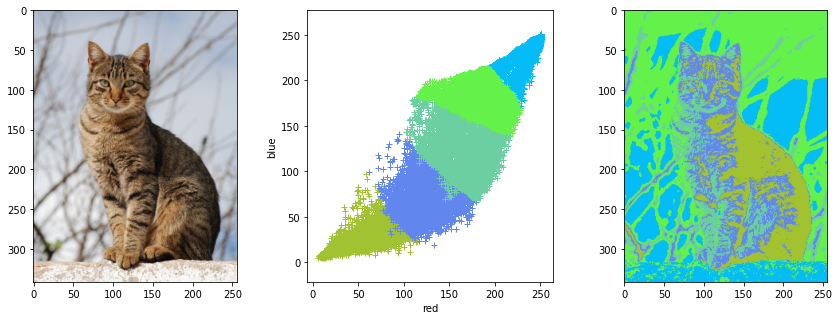

In [ ]:
from sklearn.cluster import KMeans
import cv2

def draw_segmentation(_img, seg):
  plt.rcParams['figure.figsize'] = [15, 5]
  # The number of clusters is the highest label value
  n_clusters = np.max(seg)+1
  # Create. a colour for each cluster
  colours = np.random.rand(*(n_clusters, 3))


  plt.subplot(131)
  plt.imshow(_img)
  plt.subplot(132)

  # Create an image of zeros
  seg_im = np.zeros((seg.shape[0],3), dtype=np.uint8)
  flat = np.reshape(_img, (-1, 3))
  # For each cluster, plot them in a scatter plot and fill in the seg_im
  for i in range(n_clusters):
    # Plot the red vs blue components in a scatter
    plt.plot(flat[seg==i,0], flat[seg==i,2], '+', color=colours[i,:])
    # Set the regions with a particular label to have the same colour
    seg_im[seg==i,:] = np.uint8(colours[i,:]*255)
  
  plt.xlabel('red')
  plt.ylabel('blue')
  plt.axis('equal')

  plt.subplot(133)
  
  plt.imshow(np.reshape(seg_im, _img.shape))
  plt.show()


def seg_im(_img, n_clusters=2):
  flat = np.reshape(_img, (-1, 3))
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(flat)

  # The segmentation labels based on the colour are given in kmeans.labels_
  seg = kmeans.labels_
  # Let's plot them using the function above
  draw_segmentation(_img, seg)
   

seg_im(img_cat1, 5)



# Adding some smoothness criteria
One way to encourage spatial smoothness is to use GraphCuts. This encourages adjacent pixels to have the same label. It only works for binary labels though, so for now let's using a KMeans clustering with only 2 clusters.
Don't worry too much about the details of GraphCut here, but the read the comments to help understand what's happening.

1. Write some code for fitting a KMeans cluster with only 2 clusters in the space denoted by the comment below to run the code.
2. Experiment with the smoothness weight, how does it affect the output?


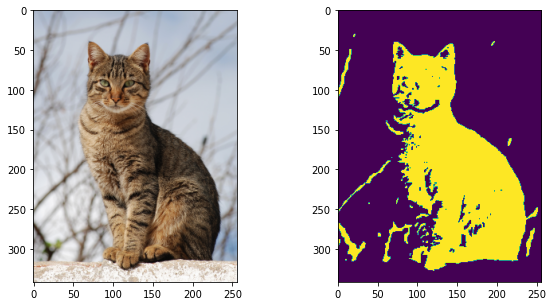

In [ ]:
def do_graph_cut_seg(_img):
  import maxflow
  plt.rcParams['figure.figsize'] = [10, 5]

  # !Insert a KMeans here with only 2 clusters.!
  data = np.reshape(_img, (-1, 3))
  kmeans = KMeans(n_clusters=2, random_state=0).fit(data)
  # Get the distance to each of the clusters (remember to remove the spatial component here)
  distance_to_clusters = kmeans.transform(data)
  # Reshape the distance to clusters back to an image
  distance_to_clusters = np.reshape(distance_to_clusters, _img.shape[0:2]+(-1,))


  # The code below is about GraphCuts
  # This parameter effects how smooth the segmentation is, try changing it!
  smoothness_weight = 15.0

  # We'll build a graph of the image
  g = maxflow.Graph[float](0, 0)
  # Adding nodes for each pixel
  nodeids = g.add_grid_nodes(distance_to_clusters.shape[0:2])
  # Set a weight for the smoothness between pixels
  g.add_grid_edges(nodeids, smoothness_weight)
  # Set the distance to cluster 1/cluster 2 as unary terms (i.e. strength to each class)
  g.add_grid_tedges(nodeids, distance_to_clusters[:,:,1], distance_to_clusters[:,:,0])
  # Calculate the max flow
  g.maxflow()
  # Get the binary segmentation
  sgm = g.get_grid_segments(nodeids)

  plt.subplot(121)
  plt.imshow(_img)
  plt.subplot(122)
  plt.imshow(sgm*1)
  plt.show()

do_graph_cut_seg(img_cat1)





# GrabCut
I've implemented a version of GrabCut, so you can see the basic steps laid out. Please take a look at the lecture notes for an overview. But briefly, GrabCut makes a probability model of the colour of pixels and outside the object you want to segment. You need to start with an initial idea of where the object is in the image, which here I've made the center with some number of pixels around it. It uses a GraphCut to make the labelling spatially smooth, and we iterate our estimation of the foreground mask. 

**Make sure you don't put too large images in here, or it will take a very long time**.

1. Read through the code, and try and understand what's going on, particularly regarding the foreground/background colour models. Don't worry about the details of GraphCut, that's outside the scope of this course.
2. Run some images through this, you might need to specify better boxes and other parameters such as number of mixture components and smoothness weights to make it work well.
3. Extend the grabcut function to take more arguments, particularly for the bounding box as well as any other parameters that seem important. The smoothness weight probably will be!
4. Cut the object out from the background based on the segmentation.


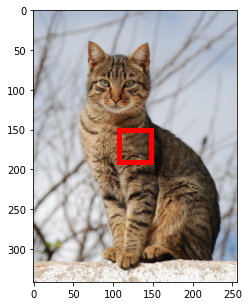

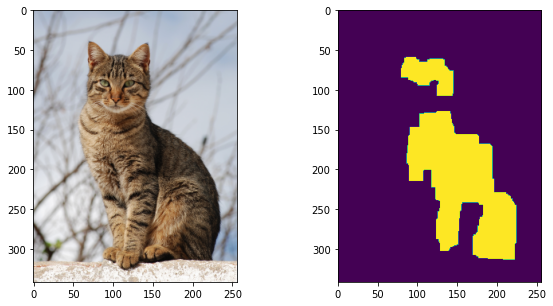

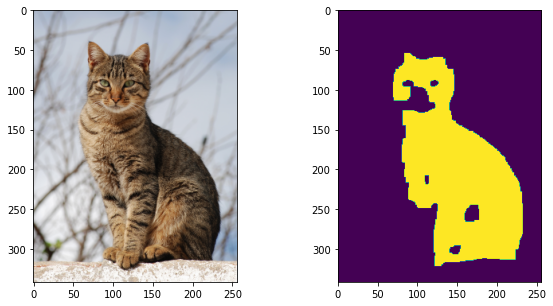

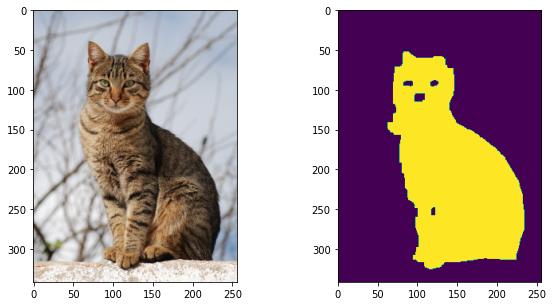

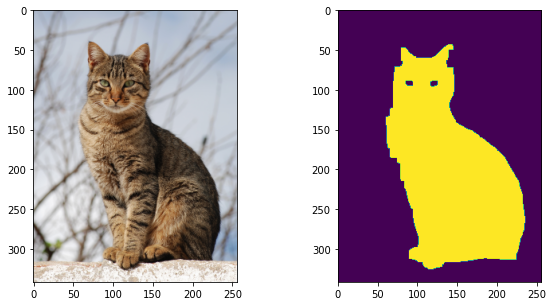

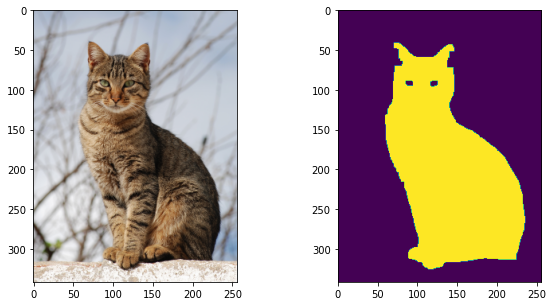

In [ ]:
def create_initial_fg_mask(_img):
  from matplotlib import patches
  # Let's create a binary image for the inital foreground mask
  fg_mask = np.zeros(_img.shape[0:2], dtype=np.bool)

  # A simple assumption about the object of interest is that it's in the centre of the
  # image and pix_around_center *2 pixels wide will give us a good starting set of pixels
  pix_around_center = 20
  fg_mask[_img.shape[0] // 2 - pix_around_center: _img.shape[0] // 2 +pix_around_center, _img.shape[1] // 2 - pix_around_center: _img.shape[1] // 2 +pix_around_center] = True

  # Draw the image with a rectangle of the box we're using for the initial foreground
  ax = plt.subplot(111)
  plt.imshow(_img)
  
  rect = patches.Rectangle((_img.shape[1] // 2 -pix_around_center, _img.shape[0]//2 - pix_around_center), pix_around_center*2, pix_around_center*2, fill=False, lw=5, color='r')
  ax.add_patch(rect)
  plt.show()
  return fg_mask

def grabcut(_img):
  import maxflow
  from sklearn.mixture import GaussianMixture
  plt.rcParams['figure.figsize'] = [10, 5]

  flat = np.reshape(_img, (-1, 3))
  # Create a mixture of Gaussians model to describe the colours of the foreground object
  fg_gmm = GaussianMixture(3)
  # Create a mixture of Gaussians model to describe the colours of the background object
  bg_gmm = GaussianMixture(5)

  fg_mask = create_initial_fg_mask(_img)
  # The initial background mask is the inverse of the foreground
  bg_mask = fg_mask == False

  # The smoothness weight is really important! Make it bigger to encourage
  # nearby pixels to have the same label
  smoothness_weight = 10
  for i in range(5):
    fg_gmm.fit(np.reshape(_img[fg_mask], (-1, 3)))
    bg_gmm.fit(np.reshape(_img[bg_mask], (-1, 3)))


    fg_lp = np.reshape(fg_gmm.score_samples(flat), _img.shape[0:2])
    bg_lp = np.reshape(bg_gmm.score_samples(flat), _img.shape[0:2])

    # The following lines are just setting up the GraphCut operation, which
    # Tries to ensure the labelling is smooth.
    g = maxflow.Graph[float](0, 0)
    nodeids = g.add_grid_nodes(_img.shape[0:2])
    # We need to add a weight for the smoothness term here
    g.add_grid_edges(nodeids, smoothness_weight)
    # We need to add the log probability of a pixel being foreground or background here
    g.add_grid_tedges(nodeids, -fg_lp, -bg_lp)
    g.maxflow()
    # Get the labelling from the maxflow/mincut
    sgm = g.get_grid_segments(nodeids)

    # Reassign the fg_mask based on our new estimate
    fg_mask = sgm
    bg_mask = sgm == False

    # Draw some stuff!
    plt.subplot(121)
    plt.imshow(_img)
    plt.subplot(122)
    plt.imshow(sgm*1)
    plt.show()

  return fg_mask


fg_mask = grabcut(img_cat1)

# Extensions
You don't have to do these, but if you complete the lab and want to learn more then give these a go! You also don't need to do them in any particular order.

+ Test out whether image pre-processing/transformation to another colour space improves your segmentation performance.
+ Try using the YOLO object detctor (see previous lab) to find the bounding box of the object and follow that up with GrabCut.
+ Add a convergence stopping criteria to GrabCut, rather than a fixed number of iterations. i.e. stop when it stops changing by a sufficient amount.
+ Paste the cut out object over a new background



